In [1]:

import torch
from segment_anything import sam_model_registry
import matplotlib.pyplot as plt
from models.sam_decoder import SAM_Decoder
from torchvision import transforms
from PIL import Image

encoder_path = '/root/ai/weights/sam_vit_b_01ec64.pth'
decoder_model_path = '/root/ai/weights/sam_enc_custom_decoder.pt'
device = 'cuda:0' if torch.cuda.is_available() else "cpu"
print(device)

sam = sam_model_registry["vit_b"](checkpoint=encoder_path)
sam = sam.to(device)

cuda:0


In [2]:
for layer_no, param in enumerate(sam.image_encoder.parameters()):
    pass
    
last_layer_no = layer_no
print("Last layer No: ", last_layer_no)
# 여기서부터 Encoder no 추가하기

Last layer No:  176


In [3]:
sam_decoder = SAM_Decoder(sam_encoder = sam.image_encoder, sam_preprocess = sam.preprocess)
sam_decoder = sam_decoder.to(device)
# 디코더 가중치 로드
sam_decoder.load_state_dict(torch.load(decoder_model_path, map_location=device))
sam_decoder.eval()
print("SAM model + Custom Decoder set to EVAL mode")

Last layer No:  176
SAM model + Custom Decoder set to EVAL mode


Np arr shape:  (1024, 1024, 1) (1024, 1024)


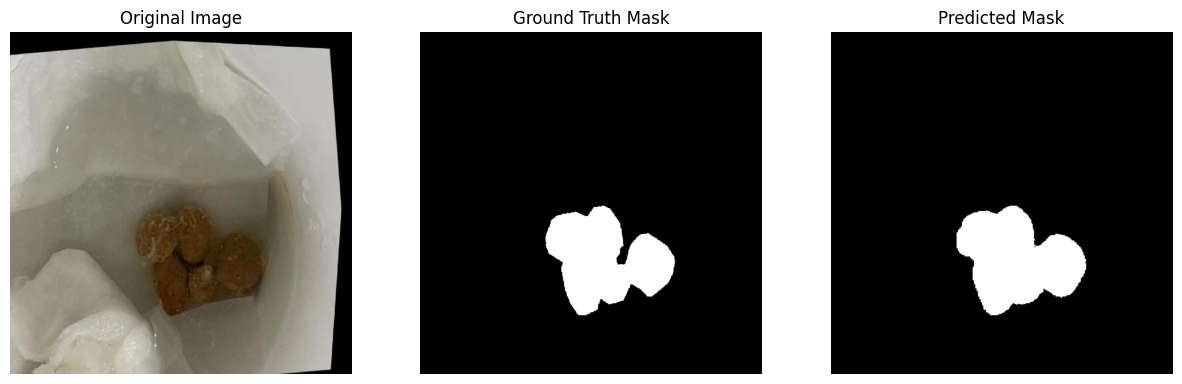

In [4]:
# 이미지 전처리
import numpy as np
import torchvision
# filename = 'Type4_iter275_jpg.rf.e2c3ef53d487afeef8bd9c69d0927e8a'
# filename = 'Type4_iter275_jpg.rf.e2c3ef53d487afeef8bd9c69d0927e8a'
filename = '33_jpeg_jpg.rf.afdfbc41a987670e2159597db4fc3f25'
input_img = f'/root/ai/dataset/mask_1513_split/img/{filename}.jpg'
mask_img = f'/root/ai/dataset/mask_1513_split/mask/{filename}_mask.png'

resize = transforms.Resize(
        (1024, 1024),
        interpolation=transforms.InterpolationMode.NEAREST
)

image = torchvision.io.read_image(input_img)
image = resize(image)

mask = torchvision.io.read_image(mask_img)
mask = resize(mask)

with torch.no_grad():
    # 모델에 입력하여 예측 수행
    pred_masks = sam_decoder(image.to(device).unsqueeze(0))

np_pred = ((pred_masks > 0.5) * 1).to("cpu").numpy()[0].transpose(1, 2, 0)

# gt_0_np는 이제 (1024, 1024) 크기로 축소됨
np_mask = mask.squeeze().to("cpu").numpy()
print("Np arr shape: ", np_pred.shape, np_mask.shape)

# 원본 이미지 변환
input_tensor_np = image.squeeze().cpu().numpy()
input_tensor_np = np.transpose(input_tensor_np, [1, 2, 0])

# 플롯 그리기
plt.figure(figsize=(15, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.imshow(input_tensor_np)
plt.title("Original Image")
plt.axis('off')

# GT 마스크
plt.subplot(1, 3, 2)
plt.imshow(np_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# 예측된 마스크
plt.subplot(1, 3, 3)
plt.imshow(np_pred, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# 플롯 표시
plt.show()

In [5]:
def predict(sam_decoder, input_path, device):
    resize = transforms.Resize((1024, 1024), interpolation=transforms.InterpolationMode.NEAREST)
    image = torchvision.io.read_image(input_path)
    image = resize(image)

    with torch.no_grad():
        pred_masks = sam_decoder(image.to(device).unsqueeze(0))
    
    np_pred = ((pred_masks > 0.5) * 1).to("cpu").numpy()[0].transpose(1, 2, 0)
    inverted_mask = 1 - np_pred  # 1이면 배경(흰색), 0이면 객체(검은색)
    original_image = image.cpu().numpy().transpose(1, 2, 0)
    white_background_image = np.ones_like(original_image) * 255
    masked_image = np.where(inverted_mask == 1, white_background_image, original_image)
    masked_image_uint8 = masked_image.squeeze().astype(np.uint8)

    return masked_image_uint8, inverted_mask.squeeze().astype(np.uint8) * 255

In [6]:
# filename = 'Type4_iter275_jpg.rf.e2c3ef53d487afeef8bd9c69d0927e8a'
filename = '33_jpeg_jpg.rf.afdfbc41a987670e2159597db4fc3f25'
input_img = f'/root/ai/dataset/mask_1513_split/img/{filename}.jpg'
mask_img = f'/root/ai/dataset/mask_1513_split/mask/{filename}_mask.png'
masked_image, mask = predict(sam_decoder, input_img, "cuda")

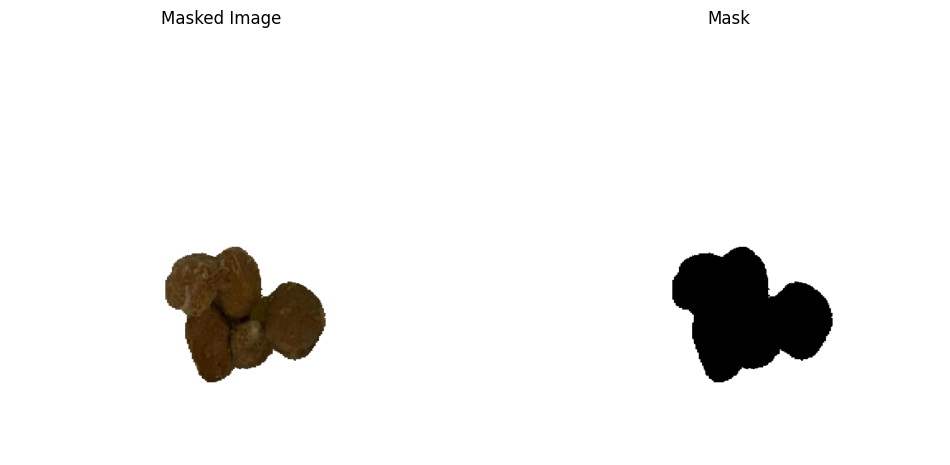

In [7]:
import matplotlib.pyplot as plt

# masked_image와 mask 변수를 전달받았다고 가정
# 아래 코드는 변수를 시각화합니다.

plt.figure(figsize=(12, 6))

# Masked Image를 시각화
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.title('Masked Image')
plt.axis('off')  # 축을 숨깁니다.

# Mask를 시각화 (회색조로 표현)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')  # 축을 숨깁니다.

plt.show()


In [8]:
import cv2 
def calculate_average_color(masked_image):
    # 배경이 흰색이므로, 흰색이 아닌 픽셀들만 선택
    non_white_mask = np.all(masked_image != [255, 255, 255], axis=-1)
    # 흰색이 아닌 픽셀들만 평균 색상 계산
    selected_pixels = masked_image[non_white_mask]
    mean_val_rgb = np.mean(selected_pixels, axis=0)
    # RGB -> BGR 순서로 변경
    mean_val_bgr = mean_val_rgb[::-1]
    return mean_val_bgr, masked_image

def calculate_average_color_path(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    mean_val = cv2.mean(masked_image, mask=mask)[:3]
    mean_val_bgr = np.array(mean_val)
    
    return mean_val_bgr, masked_image

In [9]:
m1, _ = calculate_average_color(masked_image)
m2, _ = calculate_average_color_path(input_img, mask_img)
print(m1, m2)

[15.76314776 46.0449787  69.03118209] [15.8200335  46.12690117 69.49644891]


In [10]:
def predict(sam_decoder, input_img, device):
    resize = transforms.Resize((1024, 1024), interpolation=transforms.InterpolationMode.NEAREST)
    resized_image = resize(input_img)
    image_np = np.array(resized_image)
    image = torch.from_numpy(image_np).permute(2, 0, 1).contiguous()
    print(image.shape)
    with torch.no_grad():
        pred_masks = sam_decoder(image.to(device).unsqueeze(0))
    
    np_pred = ((pred_masks > 0.5) * 1).to("cpu").numpy()[0].transpose(1, 2, 0)
    inverted_mask = 1 - np_pred  # 1이면 배경(흰색), 0이면 객체(검은색)
    original_image = image.cpu().numpy().transpose(1, 2, 0)
    white_background_image = np.ones_like(original_image) * 255
    masked_image = np.where(inverted_mask == 1, white_background_image, original_image)
    masked_image_uint8 = masked_image.squeeze().astype(np.uint8)

    return masked_image_uint8, inverted_mask.squeeze().astype(np.uint8) * 255

In [18]:
filename = '33_jpeg_jpg.rf.afdfbc41a987670e2159597db4fc3f25'
input_img = f'/root/ai/dataset/mask_1513_split/img/{filename}.jpg'
mask_img = f'/root/ai/dataset/mask_1513_split/mask/{filename}_mask.png'

input_img = "/root/ai/segmenatation/infant_poo.png"

In [19]:
input_img = Image.open(input_img)
# 사용 예시
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
masked_image, inverted_mask = predict(sam_decoder, input_img, device)

torch.Size([3, 1024, 1024])


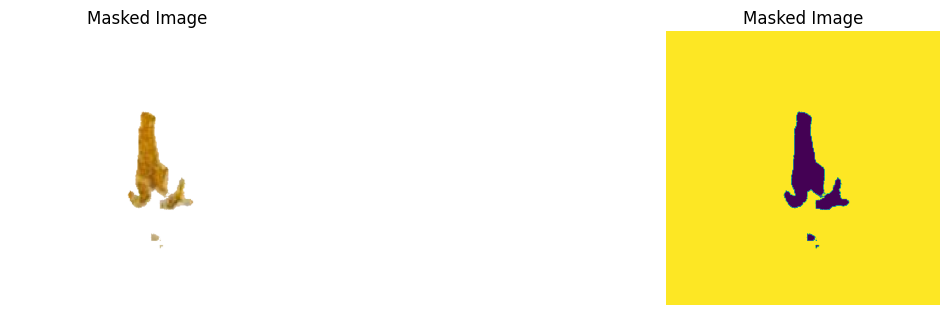

In [20]:
import matplotlib.pyplot as plt

# masked_image와 mask 변수를 전달받았다고 가정
# 아래 코드는 변수를 시각화합니다.

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title('Masked Image')
plt.axis('off')  # 축을 숨깁니다.

# Masked Image를 시각화
plt.subplot(1, 3, 1)
plt.imshow(masked_image)
plt.title('Masked Image')
plt.axis('off')  # 축을 숨깁니다.

# Masked Image를 시각화
plt.subplot(1, 3, 3)
plt.imshow(inverted_mask)
plt.title('Masked Image')
plt.axis('off')  # 축을 숨깁니다.

plt.show()
